# The purpose of this notebook is to ready the data for the training of the CRNN model (for word recognition in OCR).

In [25]:
import os, sys
import json
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

sys.path.append(os.path.abspath(os.path.join('../src')))

# add parent directory to sys.path to access data without having to put "../data"
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
# Count the number of words in the the cropped_words directory = number of files
cropped_words_dir = "../data/cropped_words/"
word_files = os.listdir(cropped_words_dir)
print(f"Number of cropped word images: {len(word_files)}")

Number of cropped word images: 2186


In [3]:
# Extract character set from JSON annotations
def extract_charset(json_path):
    chars = set()

    with open(json_path, "r") as f:
        data = json.load(f)

    for _, words in data.items():
        for entry in words:
            chars.update(entry["word"])

    chars = sorted(chars)
    return chars

# Build vocabulary mappings from character set
def build_vocab(chars):
    char2idx = {c: i + 1 for i, c in enumerate(chars)}  # 0 = blank
    idx2char = {i + 1: c for i, c in enumerate(chars)}
    blank_idx = 0
    num_classes = len(chars) + 1

    return char2idx, idx2char, blank_idx, num_classes

json_annotations_path = "../data/filename_to_word_files.json"
chars = extract_charset(json_annotations_path)
print(f"Extracted {len(chars)} unique characters from annotations.")
print(chars)

char2idx, idx2char, blank_idx, num_classes = build_vocab(chars)
print(f"Number of classes (including blank): {num_classes}")

Extracted 78 unique characters from annotations.
[' ', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '>', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
Number of classes (including blank): 79


In [11]:
# Split receipts into training and validation sets - we do this at the receipt level to avoid data leakage
def split_receipts(json_path, train_ratio=0.8, seed=42):
    random.seed(seed)

    with open(json_path, "r") as f:
        data = json.load(f)

    receipts = list(data.keys())
    random.shuffle(receipts)

    n_train = int(len(receipts) * train_ratio)

    train_receipts = receipts[:n_train]
    val_receipts = receipts[n_train:]

    return train_receipts, val_receipts

# Build samples list from receipt IDs
def build_samples(json_path, receipt_ids):
    with open(json_path, "r") as f:
        data = json.load(f)

    samples = []

    for rid in receipt_ids:
        for entry in data[rid]:
            samples.append(
                (entry["word_file"], entry["word"])
            )

    return samples


train_receipts, val_receipts = split_receipts(json_annotations_path, train_ratio=0.8, seed=42)
print(f"Number of training receipts: {len(train_receipts)}")
print(f"Number of validation receipts: {len(val_receipts)}")

train_samples = build_samples(json_annotations_path, train_receipts)
val_samples = build_samples(json_annotations_path, val_receipts)
print(f"Number of training samples (words): {len(train_samples)}")
print(f"Number of validation samples (words): {len(val_samples)}")

# print an example training sample
print(f"Example training sample: {train_samples[0]}")

Number of training receipts: 80
Number of validation receipts: 20
Number of training samples (words): 1754
Number of validation samples (words): 432
Example training sample: ('data/cropped_words/dev_receipt_00026_word_0.png', 'Rp.')


Sample 0:
  Target indices: tensor([44, 69, 11])
  Target length: 3
  Original text: Rp.


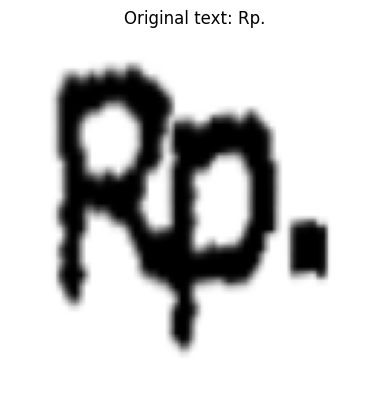

Sample 1:
  Target indices: tensor([40, 27, 45, 35])
  Target length: 4
  Original text: NASI


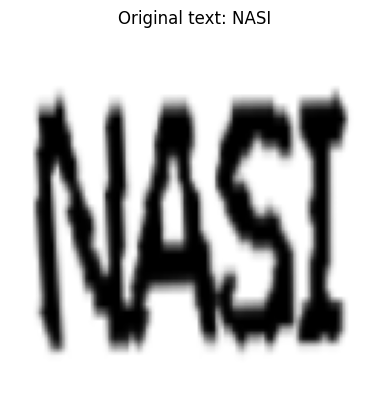

In [24]:
class OCRDataset(Dataset):
    """
    This class implements a PyTorch Dataset for our OCR task.
    It handles loading images and their corresponding text labels,
    encoding the text into indices, and applying any necessary transformations.
    """
    def __init__(self, samples, char2idx, transform=None):
        self.samples = samples
        self.char2idx = char2idx
        self.transform = transform

    def encode(self, text):
        """
        The encode method converts a text string into a tensor of character indices.
        This is essential for preparing the target labels for training the OCR model.
        """
        return torch.tensor(
            [self.char2idx[c] for c in text],
            dtype=torch.long
        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, text = self.samples[idx]

        image = Image.open(os.path.join(os.pardir, img_path)).convert("L")

        if self.transform:
            image = self.transform(image)

        target = self.encode(text)
        target_length = len(target)

        return image, target, target_length, text


# Create an instance of the OCRDataset for a subset to illustrate usage
sample_dataset = OCRDataset(train_samples[:2], char2idx)
for i in range(len(sample_dataset)):
    image, target, target_length, text = sample_dataset[i]
    print(f"Sample {i}:")
    print(f"  Target indices: {target}")
    print(f"  Target length: {target_length}")
    print(f"  Original text: {text}")
    
    # display image
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f"Original text: {text}")
    plt.axis('off')
    plt.show()

In [ ]:
# def build_transforms():
#     return T.Compose([
#         T.Resize((128, 128)),
#         T.ToTensor(),
#         T.Normalize(mean=[0.5], std=[0.5]),
#     ])


def ctc_collate_fn(batch):
    """
    Custom collate function for CTC loss that handles variable-length targets.
    """
    images, targets, target_lengths, texts = zip(*batch)

    images = torch.stack(images)
    targets = torch.cat(targets)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return images, targets, target_lengths, texts


def build_dataloaders(
    train_dataset,
    val_dataset,
    batch_size=16,
    num_workers=2
):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=ctc_collate,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=ctc_collate,
        pin_memory=True
    )

    return train_loader, val_loader
